In [0]:
#%run ./init

Hit:1 https://repos.azul.com/zulu/deb stable InRelease
Get:2 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Hit:3 http://archive.ubuntu.com/ubuntu noble InRelease
Get:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:5 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:6 http://security.ubuntu.com/ubuntu noble-security/main amd64 Components [10.1 kB]
Get:7 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1,062 kB]
Get:8 http://archive.ubuntu.com/ubuntu noble-updates/main amd64 Packages [1,219 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Components [65.0 kB]
Get:10 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Components [157 B]
Get:11 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Components [158 B]
Get:12 http://archive.ubuntu.com/ubuntu noble-updates/main amd64 Components [201 kB]
Get:13 http://archive.ubuntu.com/ubuntu noble-upd

W: https://repos.azul.com/zulu/deb/dists/stable/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.


Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (24.02.0-1ubuntu9.2).
tesseract-ocr is already the newest version (5.3.4-1build5).
0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.
/usr/bin/tesseract
/usr/bin/pdftoppm


path,name,size,modificationTime
dbfs:/databricks/init/install_poppler.sh,install_poppler.sh,142,1743112021000
dbfs:/databricks/init/install_system_dependencies.sh,install_system_dependencies.sh,203,1743216888000


Wrote 203 bytes.


True

path,name,size,modificationTime
dbfs:/databricks/init/install_poppler.sh,install_poppler.sh,142,1743112021000
dbfs:/databricks/init/install_system_dependencies.sh,install_system_dependencies.sh,203,1743432319000


/usr/bin/tesseract


pdftoppm version 24.02.0
Copyright 2005-2024 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011, 2022 Glyph & Cog, LLC


/usr/bin/pdftoppm


INFO: Image loaded successfully.
INFO:bit_infoExtractor:Image loaded successfully.


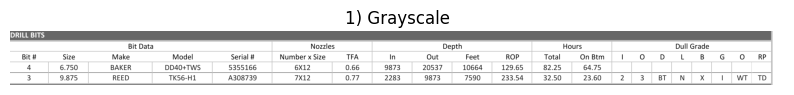

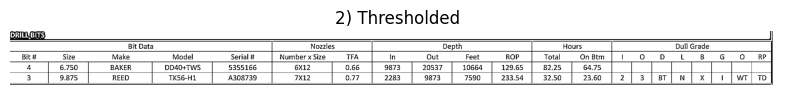

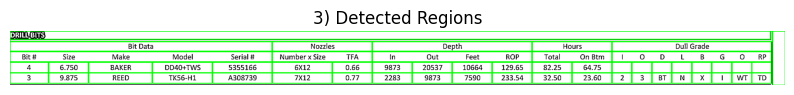

INFO: OCR Box 0 => DRILLBITS
INFO:bit_infoExtractor:OCR Box 0 => DRILLBITS
INFO: OCR Box 1 => DRILLBITS
INFO:bit_infoExtractor:OCR Box 1 => DRILLBITS
INFO: OCR Box 2 => I
INFO:bit_infoExtractor:OCR Box 2 => I
INFO: OCR Box 3 => BitData
INFO:bit_infoExtractor:OCR Box 3 => BitData
INFO: OCR Box 4 => Nozzles
INFO:bit_infoExtractor:OCR Box 4 => Nozzles
INFO: OCR Box 5 => [BLANK]
INFO:bit_infoExtractor:OCR Box 5 => [BLANK]
INFO: OCR Box 6 => Hours
INFO:bit_infoExtractor:OCR Box 6 => Hours
INFO: OCR Box 7 => DullGrade
INFO:bit_infoExtractor:OCR Box 7 => DullGrade
INFO: OCR Box 8 => Bit Size Make Model Serial
INFO:bit_infoExtractor:OCR Box 8 => Bit Size Make Model Serial
INFO: OCR Box 9 => NumberxSize TFA
INFO:bit_infoExtractor:OCR Box 9 => NumberxSize TFA
INFO: OCR Box 10 => In Out Feet ROP
INFO:bit_infoExtractor:OCR Box 10 => In Out Feet ROP
INFO: OCR Box 11 => Total OnBtm
INFO:bit_infoExtractor:OCR Box 11 => Total OnBtm
INFO: OCR Box 12 => 0 D L B G O RP
INFO:bit_infoExtractor:OCR Box 12 =

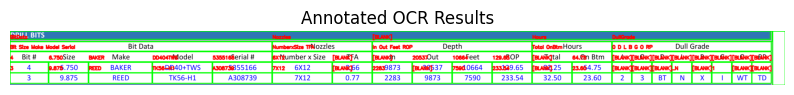

INFO: Row 0: ['DRILLBITS', 'DRILLBITS', 'I']
INFO:bit_infoExtractor:Row 0: ['DRILLBITS', 'DRILLBITS', 'I']
INFO: Row 1: ['BitData', 'Nozzles', '[BLANK]', 'Hours', 'DullGrade']
INFO:bit_infoExtractor:Row 1: ['BitData', 'Nozzles', '[BLANK]', 'Hours', 'DullGrade']
INFO: Row 2: ['Bit Size Make Model Serial', 'NumberxSize TFA', 'In Out Feet ROP', 'Total OnBtm', '0 D L B G O RP']
INFO:bit_infoExtractor:Row 2: ['Bit Size Make Model Serial', 'NumberxSize TFA', 'In Out Feet ROP', 'Total OnBtm', '0 D L B G O RP']
INFO: Row 3: ['4', '6.750', 'BAKER', 'DD404TWS', '5355166', '6X12', '[BLANK]', '[BLANK]', '20537', '10664', '129.65', '[BLANK]', '64.75', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]']
INFO:bit_infoExtractor:Row 3: ['4', '6.750', 'BAKER', 'DD404TWS', '5355166', '6X12', '[BLANK]', '[BLANK]', '20537', '10664', '129.65', '[BLANK]', '64.75', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]', '[BLANK]']
INFO: Row 4: ['3', '9.

  Bit #   Size   Make  ...     Dull Grade-G    Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...  [BLANK] [BLANK]  [BLANK] [BLANK]       [BLANK]
1     3  9.875   REED  ...       [BLANK] _N        [BLANK] 1       [BLANK]

[2 rows x 21 columns]


In [0]:
# import os
# import cv2
# import pytesseract
# import numpy as np
# import pandas as pd
# import logging
# import json
# import matplotlib.pyplot as plt
# import math

# # ---------------------------------------------------------------------
# # Logger Setup
# # ---------------------------------------------------------------------
# logger = logging.getLogger("bit_infoExtractor")
# logger.setLevel(logging.INFO)
# if not logger.handlers:
#     handler = logging.StreamHandler()
#     handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
#     logger.addHandler(handler)

# # ---------------------------------------------------------------------
# # Utility: show_image
# # ---------------------------------------------------------------------
# def show_image(title, img, cmap=None, size=(10,10)):
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # ---------------------------------------------------------------------
# # Utility: annotate_ocr_results
# # ---------------------------------------------------------------------
# def annotate_ocr_results(img, roi_texts):
#     """
#     Draws bounding boxes and OCR text on the image for debugging.
#     """
#     annotated = img.copy()
#     for (x, y, w, h, text) in roi_texts:
#         cv2.rectangle(annotated, (x, y), (x+w, y+h), (0,255,0), 2)
#         cv2.putText(annotated, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
#                     0.5, (0, 0, 255), 2, cv2.LINE_AA)
#     show_image("Annotated OCR Results", annotated)

# # ---------------------------------------------------------------------
# # Utility: safe_read_image
# # ---------------------------------------------------------------------
# def safe_read_image(img_path):
#     """
#     Reads an image from a local or DBFS path.
#     """
#     local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"File not found: {local_path}")
#     img = cv2.imread(local_path)
#     if img is None:
#         raise ValueError(f"Failed to load image: {local_path}")
#     return img

# # ---------------------------------------------------------------------
# # Utility: preprocess_image
# # ---------------------------------------------------------------------
# def preprocess_image(img, debug=False):
#     """
#     Converts image to grayscale and applies adaptive thresholding.
#     """
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if debug:
#         show_image("1) Grayscale", gray, cmap="gray")
    
#     thresh = cv2.adaptiveThreshold(
#         gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#         cv2.THRESH_BINARY, 15, 9
#     )
#     if debug:
#         show_image("2) Thresholded", thresh, cmap="gray")
#     return thresh

# # ---------------------------------------------------------------------
# # Utility: detect_text_regions
# # ---------------------------------------------------------------------
# def detect_text_regions(thresh_img, debug=False):
#     """
#     Detects text regions (bounding boxes) from the thresholded image.
#     Only keeps bounding boxes larger than (width > 30, height > 15) and
#     sorts them top-to-bottom, then left-to-right.
#     """
#     contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     rois = []
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         if w > 30 and h > 15:
#             rois.append((x, y, w, h))
    
#     rois.sort(key=lambda b: (b[1], b[0]))
    
#     if debug:
#         debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
#         for (x, y, w, h) in rois:
#             cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#         show_image("3) Detected Regions", debug_img)
    
#     return rois

# # ---------------------------------------------------------------------
# # Utility: perform_ocr_on_rois
# # ---------------------------------------------------------------------
# def perform_ocr_on_rois(img, rois, debug=False):
#     """
#     Performs OCR on each detected text region. For each region, padding is added,
#     the image is lightly dilated and upscaled, then Tesseract is applied using
#     a whitelist (with a double-escaped backslash).
#     Returns a list of tuples: (x, y, w, h, text).
#     """
#     results = []
    
#     for i, (x, y, w, h) in enumerate(rois):
#         # Add padding for better context
#         pad = 5
#         x1 = max(x - pad, 0)
#         y1 = max(y - pad, 0)
#         x2 = min(x + w + pad, img.shape[1])
#         y2 = min(y + h + pad, img.shape[0])
#         roi = img[y1:y2, x1:x2]
        
#         gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#         kernel = np.ones((1,1), np.uint8)
#         dilated = cv2.dilate(gray_roi, kernel, iterations=1)
#         thresh_roi = cv2.adaptiveThreshold(
#             dilated, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#             cv2.THRESH_BINARY, 15, 9
#         )
#         scaled_roi = cv2.resize(thresh_roi, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        
#         config_str = (
#             "--psm 6 "
#             "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#             "abcdefghijklmnopqrstuvwxyz0123456789.,:;-_/\\\\"
#         )
#         text = pytesseract.image_to_string(scaled_roi, config=config_str).strip()
        
#         # If nothing is detected, check if the region is very narrow (likely an "I")
#         if not text:
#             if (w / h) < 0.3:
#                 text = "I"
#             else:
#                 text = "[BLANK]"
        
#         results.append((x, y, w, h, text))
#         if debug:
#             logger.info(f"OCR Box {i} => {text}")
    
#     return results

# # ---------------------------------------------------------------------
# # Utility: build_bit_info_dict_from_rois (Dynamic Segmentation)
# # ---------------------------------------------------------------------
# def build_bit_info_dict_from_rois(roi_texts, debug=False):
#     """
#     Dynamically segments OCR tokens into columns based on their x-coordinate.
#     The approach:
#       1. Group OCR results into rows based on y-coordinates.
#       2. For each row, retain each token’s left x-coordinate and text.
#       3. For data rows (assumed to be rows 3+), determine the global min and max x,
#          then compute 22 equally spaced boundaries (for 21 columns).
#       4. For every row (header or data), assign tokens to columns based on these boundaries.
#       5. Map the 21 tokens per row to the final column names.
#     """
#     # Group tokens into rows by y coordinate
#     row_tolerance = 10
#     rows = []
#     current_row = []
#     prev_y = None
#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, text))
#         else:
#             rows.append(current_row)
#             current_row = [(x, text)]
#         prev_y = y
#     if current_row:
#         rows.append(current_row)
    
#     # Sort tokens in each row by their x coordinate
#     for i in range(len(rows)):
#         rows[i].sort(key=lambda tup: tup[0])
    
#     if debug:
#         for i, row in enumerate(rows):
#             logger.info(f"Row {i}: {[text for (x, text) in row]}")
    
#     # Assume rows 0-2 are headers and rows 3+ are data rows.
#     header_rows = rows[:3]
#     data_rows = rows[3:]
    
#     if not data_rows:
#         logger.warning("No data rows available for dynamic segmentation.")
#         return [], pd.DataFrame()
    
#     # Gather x coordinates from all tokens in the data rows to compute column boundaries
#     all_x = [x for row in data_rows for (x, _) in row]
#     min_x = min(all_x)
#     max_x = max(all_x)
#     # Compute 22 boundaries for 21 columns
#     boundaries = np.linspace(min_x, max_x, 22)
    
#     def assign_tokens_to_columns(row_tokens):
#         cols = [""] * 21
#         for (x, text) in row_tokens:
#             # Find the column index for the token based on its x coordinate
#             for i in range(21):
#                 if boundaries[i] <= x < boundaries[i+1]:
#                     if cols[i]:
#                         cols[i] += " " + text
#                     else:
#                         cols[i] = text
#                     break
#         return cols
    
#     # Process all rows using the computed boundaries
#     processed_rows = [assign_tokens_to_columns(row) for row in rows]
#     if debug:
#         for i, cols in enumerate(processed_rows):
#             logger.info(f"Processed Row {i}: {cols}")
    
#     # Define final column names (21 columns expected)
#     final_columns = [
#         "Bit #", "Size", "Make", "Model", "Serial #",         # 5
#         "Nozzle-(Number x Size)", "Nozzle-TFA",                # 2
#         "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",    # 4
#         "Hours-Total", "Hours-On Btm",                         # 2
#         "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L",
#         "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
#     ]
    
#     # Build structured data only from the data rows (row index 3 onward)
#     structured_data = []
#     for cols in processed_rows[3:]:
#         if len(cols) < 21:
#             cols += [""] * (21 - len(cols))
#         elif len(cols) > 21:
#             cols = cols[:21]
#         row_dict = {final_columns[i]: cols[i] for i in range(21)}
#         structured_data.append(row_dict)
#         if debug:
#             logger.info(f"Parsed row => {row_dict}")
    
#     df = pd.DataFrame(structured_data)
#     if debug:
#         logger.info("DataFrame Preview:")
#         logger.info(df.head())
    
#     df.to_csv("bit_info_data.csv", index=False)
#     logger.info("Data saved successfully as CSV.")
    
#     structured_data_json = df.to_dict(orient='records')
#     with open("bit_info_data.json", "w") as json_file:
#         json.dump(structured_data_json, json_file, indent=4)
#     logger.info("Data saved successfully in JSON format.")
    
#     return structured_data_json, df

# # ---------------------------------------------------------------------
# # Main Pipeline
# # ---------------------------------------------------------------------
# def main_bit_info_pipeline():
#     """
#     Main pipeline for extracting the BIT DETAILS table.
#     """
#     # Replace with your actual image path
#     bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"
    
#     try:
#         img = safe_read_image(bit_info_img_path)
#         logger.info("Image loaded successfully.")
#     except Exception as e:
#         logger.error(e)
#         return
    
#     # 1) Preprocess the image
#     thresh_img = preprocess_image(img, debug=True)
    
#     # 2) Detect text regions
#     rois = detect_text_regions(thresh_img, debug=True)
    
#     # 3) Perform OCR on each region
#     roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
#     # 4) Annotate the OCR results on the image
#     annotate_ocr_results(img, roi_texts)
    
#     # 5) Dynamically build structured data from OCR results
#     bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)
    
#     # 6) Log and print final JSON and DataFrame
#     final_output = {"BIT DETAILS": bit_info_list}
#     logger.info(json.dumps(final_output, indent=4))
#     print(df)
    
#     # 7) Save final results
#     output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
#     os.makedirs(output_folder, exist_ok=True)
#     with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
#         json.dump(final_output, f, indent=4)
#     df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
#     logger.info("Data saved successfully in output folder.")

# # Entry point
# if __name__ == "__main__":
#     main_bit_info_pipeline()


INFO: Image loaded successfully.
INFO:bit_infoExtractor:Image loaded successfully.


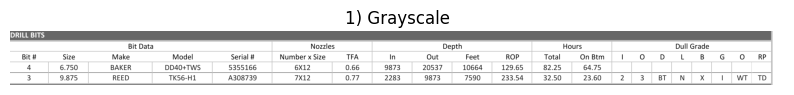

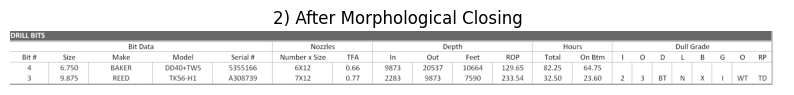

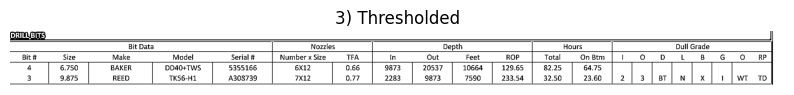

INFO: [detect_text_regions] Found 33 bounding boxes passing size filter.
INFO:bit_infoExtractor:[detect_text_regions] Found 33 bounding boxes passing size filter.


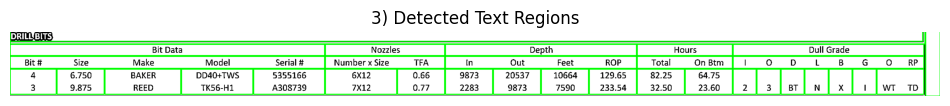

INFO: [perform_ocr_on_rois] ROI 0 (x=0, y=0, w=2461, h=34) => First pass: 'DRILLBITS'
INFO:bit_infoExtractor:[perform_ocr_on_rois] ROI 0 (x=0, y=0, w=2461, h=34) => First pass: 'DRILLBITS'
INFO: [perform_ocr_on_rois] ROI 1 (x=0, y=0, w=2455, h=27) => First pass: 'DRILLBITS'
INFO:bit_infoExtractor:[perform_ocr_on_rois] ROI 1 (x=0, y=0, w=2455, h=27) => First pass: 'DRILLBITS'
INFO: [perform_ocr_on_rois] ROI 2 (x=2463, y=0, w=39, h=173) => First pass: ''
INFO:bit_infoExtractor:[perform_ocr_on_rois] ROI 2 (x=2463, y=0, w=39, h=173) => First pass: ''
INFO: [perform_ocr_on_rois] ROI 3 (x=0, y=35, w=846, h=30) => First pass: 'BitData'
INFO:bit_infoExtractor:[perform_ocr_on_rois] ROI 3 (x=0, y=35, w=846, h=30) => First pass: 'BitData'
INFO: [perform_ocr_on_rois] ROI 4 (x=848, y=35, w=321, h=30) => First pass: 'Nozzles'
INFO:bit_infoExtractor:[perform_ocr_on_rois] ROI 4 (x=848, y=35, w=321, h=30) => First pass: 'Nozzles'
INFO: [perform_ocr_on_rois] ROI 5 (x=1171, y=35, w=514, h=30) => First pa

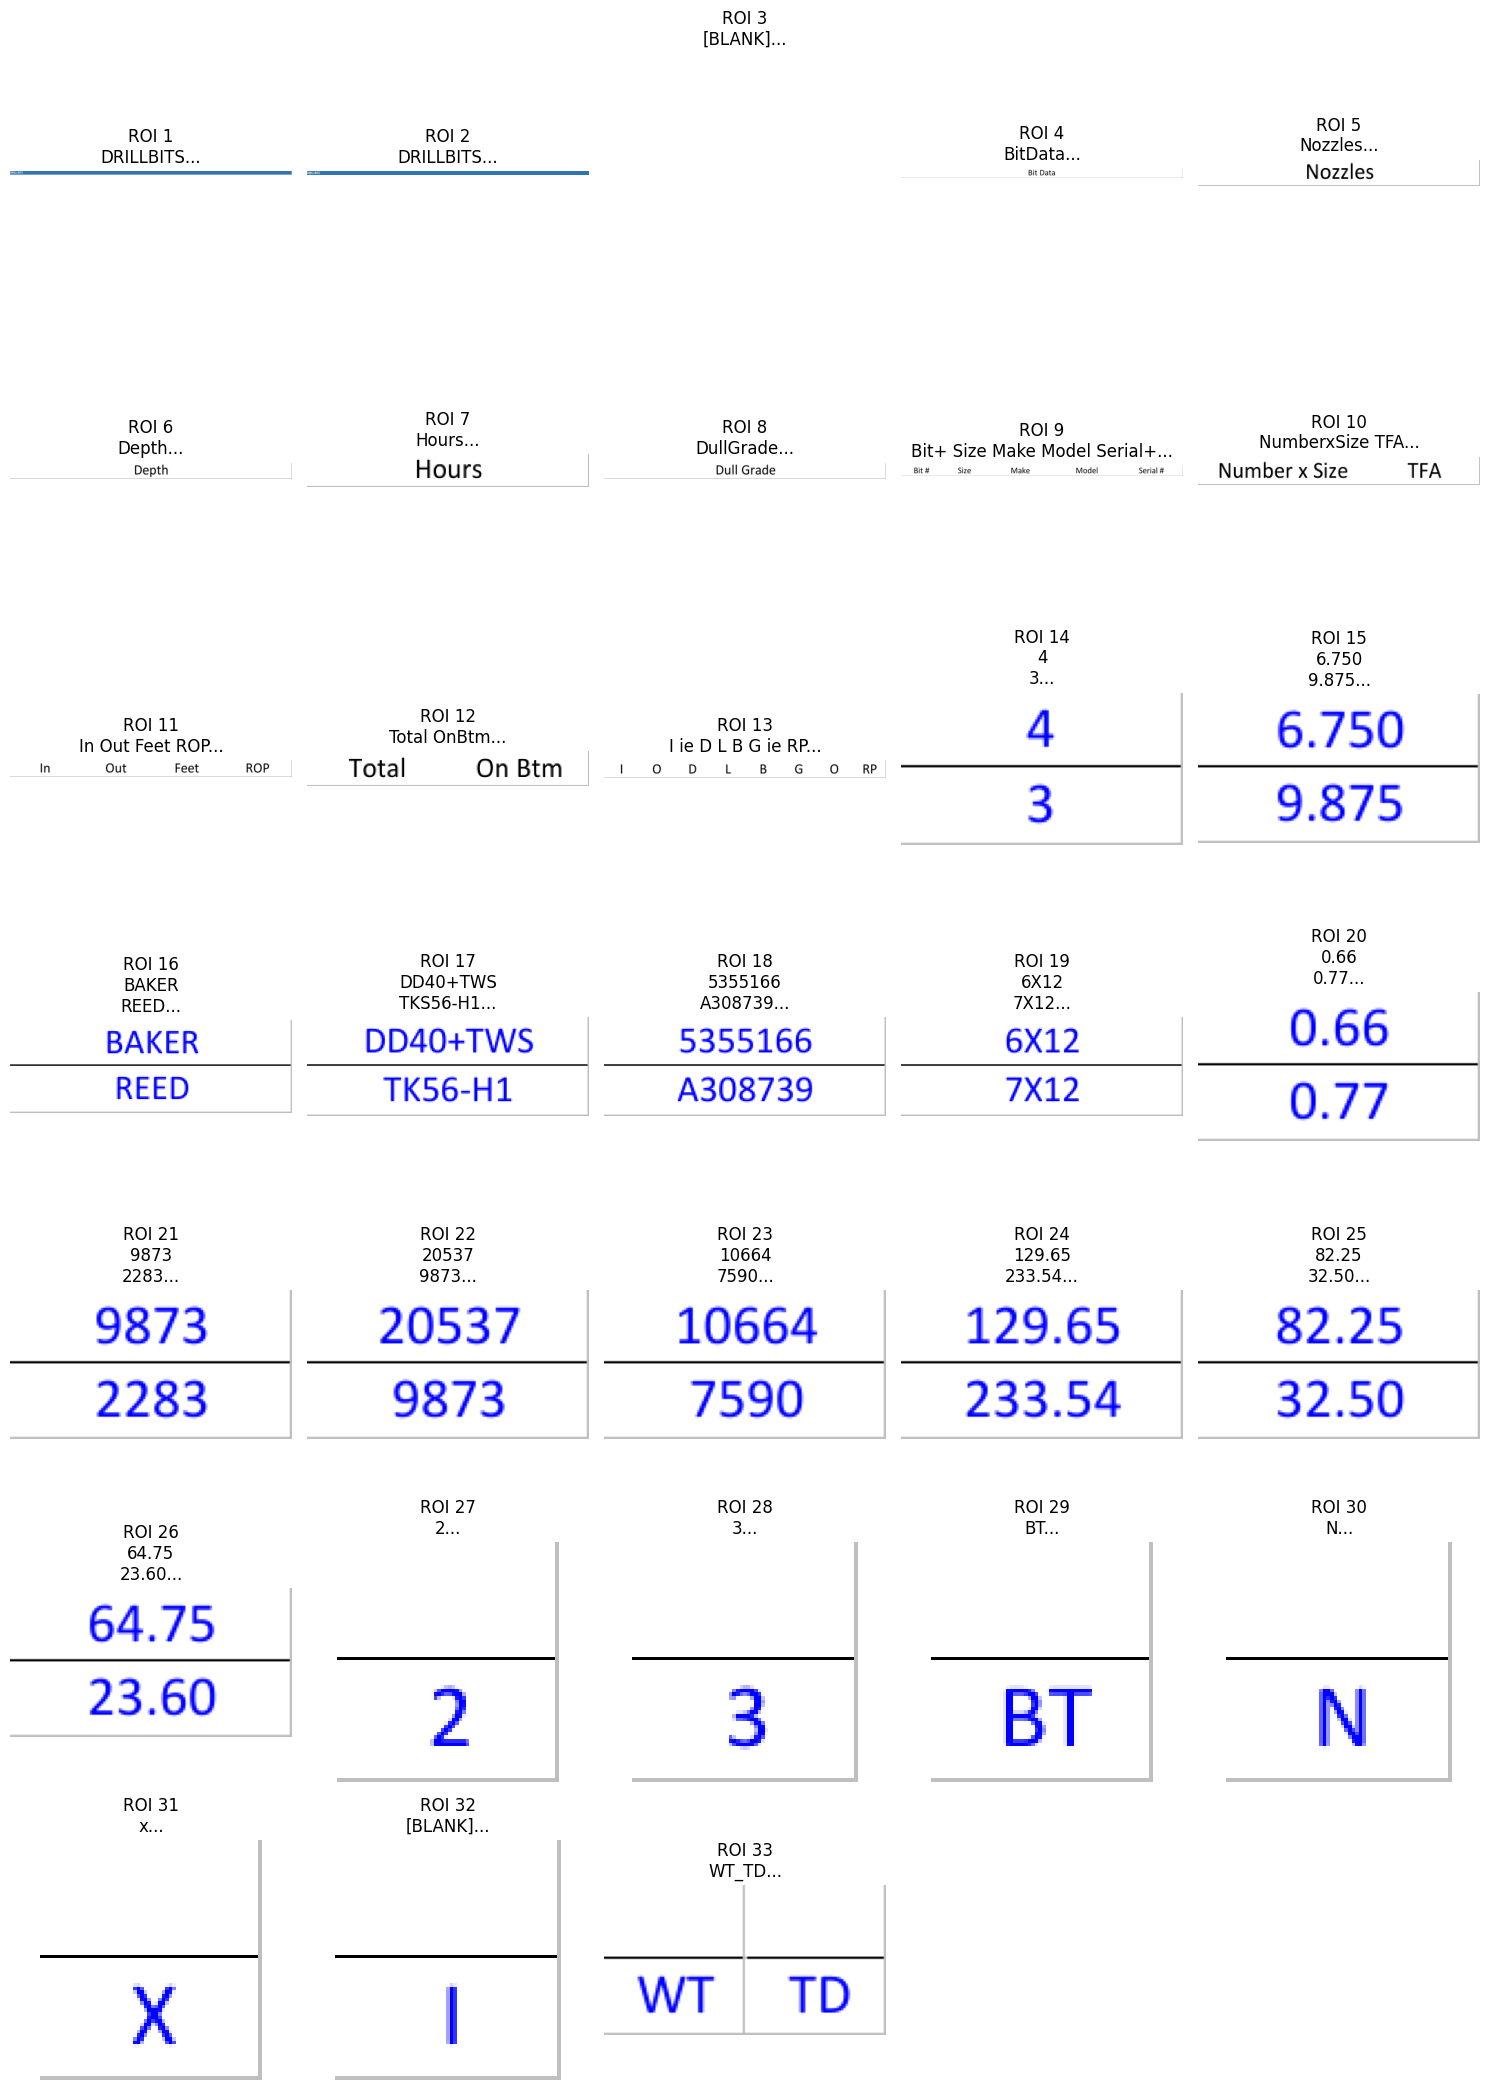

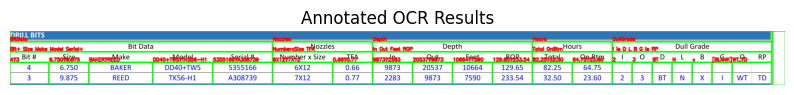

INFO: [build_bit_info_dict_from_rois] Row 0 => DRILLBITS DRILLBITS [BLANK]
INFO:bit_infoExtractor:[build_bit_info_dict_from_rois] Row 0 => DRILLBITS DRILLBITS [BLANK]
INFO: [build_bit_info_dict_from_rois] Row 1 => BitData Nozzles Depth Hours DullGrade
INFO:bit_infoExtractor:[build_bit_info_dict_from_rois] Row 1 => BitData Nozzles Depth Hours DullGrade
INFO: [build_bit_info_dict_from_rois] Row 2 => Bit+ Size Make Model Serial+ NumberxSize TFA In Out Feet ROP Total OnBtm I ie D L B G ie RP
INFO:bit_infoExtractor:[build_bit_info_dict_from_rois] Row 2 => Bit+ Size Make Model Serial+ NumberxSize TFA In Out Feet ROP Total OnBtm I ie D L B G ie RP
INFO: [build_bit_info_dict_from_rois] Row 3 => 4 3 6.750 9.875 BAKER REED DD40+TWS TKS56-H1 5355166 A308739 6X12 7X12 0.66 0.77 9873 2283 20537 9873 10664 7590 129.65 233.54 82.25 32.50 64.75 23.60 2 3 BT N x [BLANK] WT_TD
INFO:bit_infoExtractor:[build_bit_info_dict_from_rois] Row 3 => 4 3 6.750 9.875 BAKER REED DD40+TWS TKS56-H1 5355166 A308739 6X1

  Bit # Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4    3  6.750  ...        10664          7590        129.65

[1 rows x 21 columns]


In [0]:
# import os
# import re
# import cv2
# import pytesseract
# import numpy as np
# import pandas as pd
# import logging
# import json
# import matplotlib.pyplot as plt
# import math

# # ---------------------------------------------------------------------
# # Logger Setup
# # ---------------------------------------------------------------------
# logger = logging.getLogger("bit_infoExtractor")
# logger.setLevel(logging.INFO)
# if not logger.handlers:
#     handler = logging.StreamHandler()
#     handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
#     logger.addHandler(handler)

# # ---------------------------------------------------------------------
# # Utility: show_image
# # ---------------------------------------------------------------------
# def show_image(title, img, cmap=None, size=(10,10)):
#     plt.figure(figsize=size)
#     if cmap:
#         plt.imshow(img, cmap=cmap)
#     else:
#         if len(img.shape) == 3:
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         else:
#             plt.imshow(img, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # ---------------------------------------------------------------------
# # annotate_ocr_results
# # ---------------------------------------------------------------------
# def annotate_ocr_results(img, roi_texts):
#     """
#     Draws bounding boxes and OCR text on the image for debugging.
#     """
#     annotated = img.copy()
#     for (x, y, w, h, text) in roi_texts:
#         cv2.rectangle(annotated, (x, y), (x+w, y+h), (0,255,0), 2)
#         cv2.putText(annotated, text, (x, y-5),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
#     show_image("Annotated OCR Results", annotated)

# # ---------------------------------------------------------------------
# # safe_read_image
# # ---------------------------------------------------------------------
# def safe_read_image(img_path):
#     """
#     Reads an image from a local or DBFS path.
#     """
#     local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
#     if not os.path.exists(local_path):
#         raise FileNotFoundError(f"File not found: {local_path}")
#     img = cv2.imread(local_path)
#     if img is None:
#         raise ValueError(f"Failed to load image: {local_path}")
#     return img

# # ---------------------------------------------------------------------
# # preprocess_image
# # ---------------------------------------------------------------------
# def preprocess_image(img, debug=False):
#     """
#     Converts image to grayscale, applies morphological closing,
#     then applies adaptive thresholding.
#     """
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if debug:
#         show_image("1) Grayscale", gray, cmap="gray")

#     # Morphological closing to help keep thin strokes (like 'I')
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
#     closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
#     if debug:
#         show_image("2) After Morphological Closing", closed, cmap="gray")

#     # Adaptive threshold
#     thresh = cv2.adaptiveThreshold(
#         closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#         cv2.THRESH_BINARY, 15, 9
#     )
#     if debug:
#         show_image("3) Thresholded", thresh, cmap="gray")
#     return thresh

# # ---------------------------------------------------------------------
# # detect_text_regions
# # ---------------------------------------------------------------------
# def detect_text_regions(thresh_img, debug=True):
#     """
#     Detects text regions (bounding boxes) from the thresholded image.
#     We keep bounding boxes > (w=30, h=15).
#     """
#     contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     rois = []
#     debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         if w > 30 and h > 15:
#             rois.append((x, y, w, h))
#             cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
#     rois.sort(key=lambda b: (b[1], b[0]))
#     if debug:
#         logger.info(f"[detect_text_regions] Found {len(rois)} bounding boxes passing size filter.")
#         show_image("3) Detected Text Regions", debug_img, size=(12,12))
#     return rois

# # ---------------------------------------------------------------------
# # perform_ocr_on_rois
# # ---------------------------------------------------------------------
# def perform_ocr_on_rois(img, rois, debug=True):
#     """
#     Performs OCR on each detected text region with Tesseract config.
#     If Tesseract returns blank for a suspiciously narrow ROI,
#     we do a second pass with morphological dilation + PSM 10
#     (single char mode).
#     """
#     results = []
#     n = len(rois)

#     if debug and n > 0:
#         cols = 5
#         rows = math.ceil(n / cols)
#         fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
#         axes = axes.flatten() if rows > 1 else [axes]

#     # Normal Tesseract config (PSM 6, with a whitelist)
#     normal_config = (
#         "--psm 6 "
#         "-c tessedit_char_whitelist="
#         "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#         "abcdefghijklmnopqrstuvwxyz"
#         "0123456789_./\\-+"
#     )

#     # Second-pass config (PSM 10 for single character)
#     single_char_config = (
#         "--psm 10 "
#         "-c tessedit_char_whitelist="
#         "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#         "abcdefghijklmnopqrstuvwxyz"
#         "0123456789_./\\-+"
#     )

#     for i, (x, y, w, h) in enumerate(rois):
#         roi = img[y:y+h, x:x+w]

#         # --- First pass OCR ---
#         text = pytesseract.image_to_string(roi, config=normal_config).strip()
#         if debug:
#             logger.info(f"[perform_ocr_on_rois] ROI {i} (x={x}, y={y}, w={w}, h={h}) => First pass: '{text}'")

#         # If blank and bounding box is narrow (e.g. w < 20),
#         # try second pass with morphological dilation + PSM 10
#         if (not text) and (w < 20):
#             if debug:
#                 logger.info(f"[perform_ocr_on_rois] ROI {i} => First pass blank & w<20; attempting second pass.")

#             # Dilate the ROI a bit to emphasize thin strokes
#             kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
#             roi_dilated = cv2.dilate(roi, kernel, iterations=1)

#             # Second pass
#             text2 = pytesseract.image_to_string(roi_dilated, config=single_char_config).strip()
#             if debug:
#                 logger.info(f"[perform_ocr_on_rois] ROI {i} => Second pass result: '{text2}'")

#             if text2:
#                 text = text2  # Use second-pass result
#             else:
#                 text = "[BLANK]"
#         elif not text:
#             # If blank but not narrow, keep blank
#             text = "[BLANK]"

#         results.append((x, y, w, h, text))

#         if debug and i < len(axes):
#             roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#             axes[i].imshow(roi_rgb)
#             axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
#             axes[i].axis("off")

#     if debug and n > 0:
#         # Turn off any extra subplot axes
#         for j in range(i + 1, len(axes)):
#             axes[j].axis("off")
#         plt.tight_layout()
#         plt.show()

#     return results

# # ---------------------------------------------------------------------
# # build_bit_info_dict_from_rois
# # ---------------------------------------------------------------------
# def build_bit_info_dict_from_rois(roi_texts, debug=True):
#     """
#     Groups bounding boxes into rows, merges text in left->right order,
#     then parses them into a final structure.
#     """
#     row_tolerance = 3  # keep it small to avoid merging separate lines
#     grouped_rows = []
#     current_row = []
#     prev_y = None

#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, y, w, h, text))
#         else:
#             grouped_rows.append(current_row)
#             current_row = [(x, y, w, h, text)]
#         prev_y = y
#     if current_row:
#         grouped_rows.append(current_row)

#     row_strings = []
#     for i, row_cells in enumerate(grouped_rows):
#         row_cells.sort(key=lambda c: c[0])  # left->right
#         line = " ".join(cell[4] for cell in row_cells)
#         line = line.replace("\n", " ").strip()
#         if debug:
#             logger.info(f"[build_bit_info_dict_from_rois] Row {i} => {line}")
#         row_strings.append(line)

#     if len(row_strings) < 3:
#         logger.warning("[build_bit_info_dict_from_rois] Not enough rows found for this layout.")
#         return [], pd.DataFrame()

#     # Row 0 => Title
#     super_header_line = row_strings[1] if len(row_strings) > 1 else ""
#     sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
#     data_lines        = row_strings[3:]  # subsequent lines

#     if debug:
#         logger.info(f"[build_bit_info_dict_from_rois] Super Headers => {super_header_line}")
#         logger.info(f"[build_bit_info_dict_from_rois] Sub Headers => {sub_header_line}")
#         logger.info(f"[build_bit_info_dict_from_rois] Data Lines => {data_lines}")

#     final_columns = [
#         "Bit #", "Size", "Make", "Model", "Serial #",         # 5
#         "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
#         "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
#         "Hours-Total", "Hours-On Btm",                        # 2
#         "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L",
#         "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
#     ]
#     expected_token_count = len(final_columns)

#     structured_data = []
#     for line in data_lines:
#         tokens = line.split()
#         if len(tokens) < expected_token_count:
#             tokens += ["[BLANK]"] * (expected_token_count - len(tokens))
#         elif len(tokens) > expected_token_count:
#             tokens = tokens[:expected_token_count]

#         row_dict = {}
#         for col_idx, col_name in enumerate(final_columns):
#             row_dict[col_name] = tokens[col_idx] if col_idx < len(tokens) else "[BLANK]"
#         if debug:
#             logger.info(f"[build_bit_info_dict_from_rois] Parsed row => {row_dict}")
#         structured_data.append(row_dict)

#     df = pd.DataFrame(structured_data)

#     # No forced "I" fix here (fix_suspicious_I removed)

#     if debug:
#         logger.info("[build_bit_info_dict_from_rois] DataFrame Preview:")
#         logger.info(df.head().to_string())

#     df.to_csv("bit_info_data.csv", index=False)
#     logger.info("Data saved successfully as CSV.")

#     structured_data_json = df.to_dict(orient='records')
#     with open("bit_info_data.json", "w") as json_file:
#         json.dump(structured_data_json, json_file, indent=4)
#     logger.info("Data saved successfully in JSON format.")

#     return structured_data_json, df

# # ---------------------------------------------------------------------
# # main_bit_info_pipeline
# # ---------------------------------------------------------------------
# def main_bit_info_pipeline():
#     """
#     Main pipeline for extracting the BIT DETAILS table from your layout.
#     """
#     # Replace with your actual path
#     bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"

#     try:
#         img = safe_read_image(bit_info_img_path)
#         logger.info("Image loaded successfully.")
#     except Exception as e:
#         logger.error(e)
#         return

#     # 1) Preprocess
#     thresh_img = preprocess_image(img, debug=True)

#     # 2) Detect bounding boxes
#     rois = detect_text_regions(thresh_img, debug=True)

#     # 3) Perform OCR
#     roi_texts = perform_ocr_on_rois(img, rois, debug=True)

#     # 4) Annotate and show OCR results on the image
#     annotate_ocr_results(img, roi_texts)

#     # 5) Build structured data
#     bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)

#     # 6) Show final JSON in logs
#     final_output = {"BIT DETAILS": bit_info_list}
#     logger.info(json.dumps(final_output, indent=4))
#     print(df)

#     # 7) Save final results
#     output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
#     os.makedirs(output_folder, exist_ok=True)
#     with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
#         json.dump(final_output, f, indent=4)
#     df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
#     logger.info("Data saved successfully in output folder.")

# if __name__ == "__main__":
#     main_bit_info_pipeline()


INFO: Image loaded successfully.
INFO:bit_infoExtractor:Image loaded successfully.


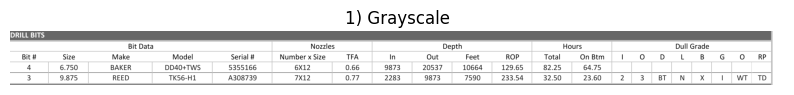

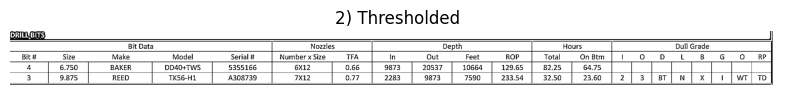

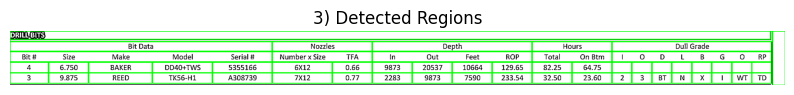

INFO: OCR Box 0: DRILL BITS
INFO:bit_infoExtractor:OCR Box 0: DRILL BITS
INFO: OCR Box 1: DRILL BITS
INFO:bit_infoExtractor:OCR Box 1: DRILL BITS
INFO: OCR Box 2: [BLANK]
INFO:bit_infoExtractor:OCR Box 2: [BLANK]
INFO: OCR Box 3: Bit Data
INFO:bit_infoExtractor:OCR Box 3: Bit Data
INFO: OCR Box 4: Nozzles
INFO:bit_infoExtractor:OCR Box 4: Nozzles
INFO: OCR Box 5: Depth
INFO:bit_infoExtractor:OCR Box 5: Depth
INFO: OCR Box 6: Hours
INFO:bit_infoExtractor:OCR Box 6: Hours
INFO: OCR Box 7: Dull Grade
INFO:bit_infoExtractor:OCR Box 7: Dull Grade
INFO: OCR Box 8: Bit # Size Make Model Serial #
INFO:bit_infoExtractor:OCR Box 8: Bit # Size Make Model Serial #
INFO: OCR Box 9: Number x Size TFA
INFO:bit_infoExtractor:OCR Box 9: Number x Size TFA
INFO: OCR Box 10: In Out Feet ROP
INFO:bit_infoExtractor:OCR Box 10: In Out Feet ROP
INFO: OCR Box 11: Total On Btm
INFO:bit_infoExtractor:OCR Box 11: Total On Btm
INFO: OCR Box 12: I [@) D L B G [e) RP
INFO:bit_infoExtractor:OCR Box 12: I [@) D L B G 

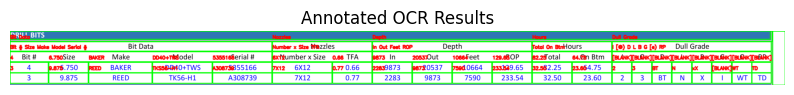

INFO: Row 0 => DRILL BITS DRILL BITS [BLANK]
INFO:bit_infoExtractor:Row 0 => DRILL BITS DRILL BITS [BLANK]
INFO: Row 1 => Bit Data Nozzles Depth Hours Dull Grade
INFO:bit_infoExtractor:Row 1 => Bit Data Nozzles Depth Hours Dull Grade
INFO: Row 2 => Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I [@) D L B G [e) RP
INFO:bit_infoExtractor:Row 2 => Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I [@) D L B G [e) RP
INFO: Row 3 => 4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75 [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:bit_infoExtractor:Row 3 => 4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75 [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Row 4 => 3 9.875 REED TKS56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 2 3 BT N xX [BLANK] WT TD
INFO:bit_infoExtractor:Row 4 => 3 9.875 REED TKS56-H1 A308739 7X12 0.77 2283 

  Bit #   Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...      [BLANK]       [BLANK]       [BLANK]
1     3  9.875   REED  ...      [BLANK]            WT            TD

[2 rows x 21 columns]


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("bit_infoExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# New Utility: annotate_ocr_results
# ---------------------------------------------------------------------
def annotate_ocr_results(img, roi_texts):
    """
    Draws bounding boxes and OCR text on the image for debugging.
    """
    annotated = img.copy()
    for (x, y, w, h, text) in roi_texts:
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0,255,0), 2)
        # Place the OCR text above the bounding box; adjust as needed.
        cv2.putText(annotated, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 2, cv2.LINE_AA)
    show_image("Annotated OCR Results", annotated)

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a local or DBFS path.
    """
    local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    Only keeps bounding boxes larger than (width>30, height>15).
    Sort them top-to-bottom, then left-to-right.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    
    rois.sort(key=lambda b: (b[1], b[0]))  # top->bottom, then left->right

    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("3) Detected Regions", debug_img)
    
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns list of tuples: (x, y, w, h, text).
    """
    results = []
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        # Using a whitelist can be added here if needed:
        # config_str = "--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box {i}: {text}")
    return results

# ---------------------------------------------------------------------
# build_bit_info_dict_from_rois
# ---------------------------------------------------------------------
def build_bit_info_dict_from_rois(roi_texts, debug=False):
    """
    Custom parsing for the multi-row header layout:
      Row 0 => Table Title (e.g. "DRILL BITS ...")
      Row 1 => Super Headers: "Bit Data  Nozzles  Depth  Hours  Dull Grade"
      Row 2 => Sub-headers:   "Bit # Size Make Model Serial #  Number x Size TFA  In Out Feet ROP  Total On Btm  I oO D L B G oO RP"
      Row 3 => Data row #1
      Row 4 => Data row #2
      ...
    We'll parse row 1 and row 2 to define column groups. Then parse each subsequent row in chunks.
    """
    # Step 1) Group bounding boxes by y-coordinate
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)

    # Step 2) Convert each row group into a single string
    row_strings = []
    for i, row_cells in enumerate(grouped_rows):
        row_cells.sort(key=lambda c: c[0])  # left->right
        line = " ".join(cell[4] for cell in row_cells)
        line = line.replace("\n", " ").strip()  # flatten
        row_strings.append(line)
        if debug:
            logger.info(f"Row {i} => {line}")

    # We expect something like:
    # Row 0 => "DRILL BITS DRILL BITS [BLANK]"
    # Row 1 => "Bit Data Nozzles Depth Hours Dull Grade"
    # Row 2 => "Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I oO D L B G oO RP"
    # Row 3 => "4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 ..."
    # Row 4 => "3 9.875 REED TKS6-H1 A308739 7X12 0.77 ..."

    # Step 3) Identify the row indices for:
    #  - Title (row 0)
    #  - Super headers (row 1)
    #  - Sub-headers (row 2)
    #  - Data rows (row 3, 4, ...)
    if len(row_strings) < 3:
        logger.warning("Not enough rows found for this layout.")
        return [], pd.DataFrame()

    # We'll skip row 0 (table title).
    super_header_line = row_strings[1] if len(row_strings) > 1 else ""
    sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
    data_lines        = row_strings[3:]  # everything after row 2

    if debug:
        logger.info(f"Super Headers => {super_header_line}")
        logger.info(f"Sub Headers => {sub_header_line}")
        logger.info(f"Data Lines => {data_lines}")

    # Step 4) Define the "super header" groups and sub-headers
    # We'll do a simpler approach: we know how many tokens each group has:
    #  Bit Data => 5, Nozzles => 2, Depth => 4, Hours => 2, Dull Grade => 8 (Total = 21)
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
        "Hours-Total", "Hours-On Btm",                        # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]

    # Step 5) Parse each data row in chunks of 21 tokens
    structured_data = []
    for line in data_lines:
        tokens = line.split()
        # We expect 21 tokens per data row; pad or truncate if necessary
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]

        row_dict = {}
        for col_idx, col_name in enumerate(final_columns):
            row_dict[col_name] = tokens[col_idx] if col_idx < len(tokens) else ""

        structured_data.append(row_dict)
        if debug:
            logger.info(f"Parsed row => {row_dict}")

    # Step 6) Convert to DataFrame and JSON
    df = pd.DataFrame(structured_data)
    if debug:
        logger.info("DataFrame Preview:")
        logger.info(df.head())

    df.to_csv("bit_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")

    structured_data_json = df.to_dict(orient='records')
    with open("bit_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")

    return structured_data_json, df

# ---------------------------------------------------------------------
# main_bit_info_pipeline
# ---------------------------------------------------------------------
def main_bit_info_pipeline():
    """
    Main pipeline for extracting the BIT DETAILS table from your layout.
    """
    # Replace with your actual path
    bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"

    try:
        img = safe_read_image(bit_info_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Preprocess
    thresh_img = preprocess_image(img, debug=True)

    # 2) Detect bounding boxes
    rois = detect_text_regions(thresh_img, debug=True)

    # 3) Perform OCR
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # --- New Step: Annotate and show OCR results on the image ---
    annotate_ocr_results(img, roi_texts)

    # 4) Build structured data (tailored to your table layout)
    bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)

    # 5) Show final JSON in logs
    final_output = {"BIT DETAILS": bit_info_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    # 6) Save final results
    output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")

if __name__ == "__main__":
    main_bit_info_pipeline()


INFO: Image loaded successfully.
INFO:bit_infoExtractor:Image loaded successfully.


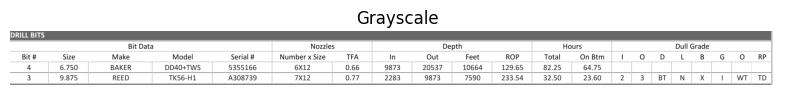

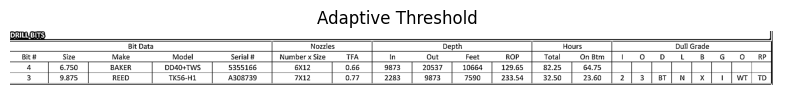

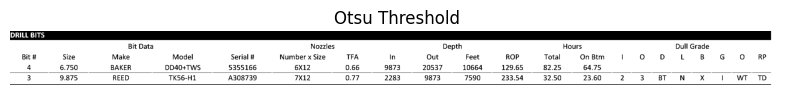

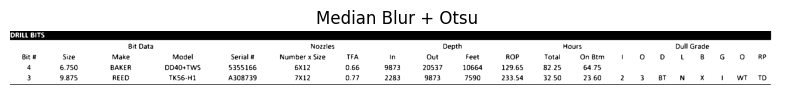

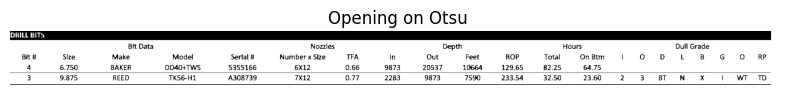

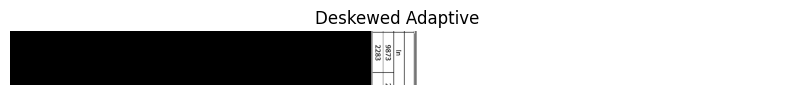

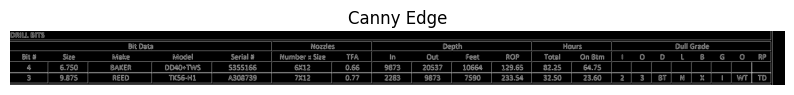

INFO: OCR result for 'gray': Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | ie) D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 | 2) 3 | BT) N| X| 1 /|WT TD.
INFO:bit_infoExtractor:OCR result for 'gray': Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | ie) D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 | 2) 3 | BT) N| X| 1 /|WT TD.
INFO: OCR result for 'adaptive': DRILUBITS}

Bit Data
are Swe Make Model Serial
4 [6750 [BAKER | DoaoeTwS | sassiss | exiz__-| 06s | 9873 | 2037 | 1066 | a2965 | e225] 6475 || | | | | | | _
3 | 987s | reco | Txs6-H1 | aaoa7a0__| 7x12 | 077_| 2283 | 9873 | 7590 | 23354 | 3250 | 2360 | 2] 3


--- OCR Results for Different Preprocessing Methods ---
gray: Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | ie) D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 | 2) 3 | BT) N| X| 1 /|WT TD.
adaptive: DRILUBITS}

Bit Data
are Swe Make Model Serial
4 [6750 [BAKER | DoaoeTwS | sassiss | exiz__-| 06s | 9873 | 2037 | 1066 | a2965 | e225] 6475 || | | | | | | _
3 | 987s | reco | Txs6-H1 | aaoa7a0__| 7x12 | 077_| 2283 | 9873 | 7590 | 23354 | 3250 | 2360 | 2] 31a7ln|x|1|w 7)
otsu: Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | oO D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 2360 2 #3 BT N X | WI TD
otsu_blur: Bit Data Nozzl

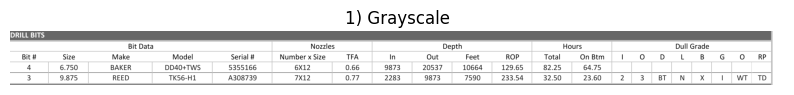

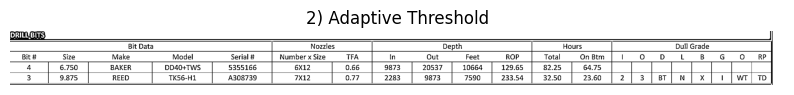

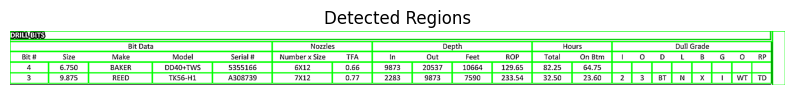

INFO: OCR Box 0: DRILL BITS
INFO:bit_infoExtractor:OCR Box 0: DRILL BITS
INFO: OCR Box 1: DRILL BITS
INFO:bit_infoExtractor:OCR Box 1: DRILL BITS
INFO: OCR Box 2: [BLANK]
INFO:bit_infoExtractor:OCR Box 2: [BLANK]
INFO: OCR Box 3: Bit Data
INFO:bit_infoExtractor:OCR Box 3: Bit Data
INFO: OCR Box 4: Nozzles
INFO:bit_infoExtractor:OCR Box 4: Nozzles
INFO: OCR Box 5: Depth
INFO:bit_infoExtractor:OCR Box 5: Depth
INFO: OCR Box 6: Hours
INFO:bit_infoExtractor:OCR Box 6: Hours
INFO: OCR Box 7: Dull Grade
INFO:bit_infoExtractor:OCR Box 7: Dull Grade
INFO: OCR Box 8: Bit # Size Make Model Serial #
INFO:bit_infoExtractor:OCR Box 8: Bit # Size Make Model Serial #
INFO: OCR Box 9: Number x Size TFA
INFO:bit_infoExtractor:OCR Box 9: Number x Size TFA
INFO: OCR Box 10: In Out Feet ROP
INFO:bit_infoExtractor:OCR Box 10: In Out Feet ROP
INFO: OCR Box 11: Total On Btm
INFO:bit_infoExtractor:OCR Box 11: Total On Btm
INFO: OCR Box 12: I [@) D L B G [e) RP
INFO:bit_infoExtractor:OCR Box 12: I [@) D L B G 

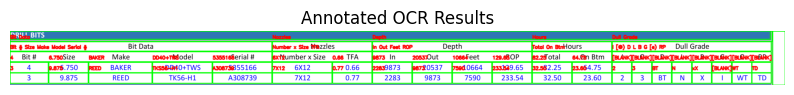

INFO: Row 0 => DRILL BITS DRILL BITS [BLANK]
INFO:bit_infoExtractor:Row 0 => DRILL BITS DRILL BITS [BLANK]
INFO: Row 1 => Bit Data Nozzles Depth Hours Dull Grade
INFO:bit_infoExtractor:Row 1 => Bit Data Nozzles Depth Hours Dull Grade
INFO: Row 2 => Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I [@) D L B G [e) RP
INFO:bit_infoExtractor:Row 2 => Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm I [@) D L B G [e) RP
INFO: Row 3 => 4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75 [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:bit_infoExtractor:Row 3 => 4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75 [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Row 4 => 3 9.875 REED TKS56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 2 3 BT N xX [BLANK] WT TD
INFO:bit_infoExtractor:Row 4 => 3 9.875 REED TKS56-H1 A308739 7X12 0.77 2283 

  Bit #   Size   Make  ... Dull Grade-G Dull Grade-O2 Dull Grade-RP
0     4  6.750  BAKER  ...      [BLANK]       [BLANK]       [BLANK]
1     3  9.875   REED  ...      [BLANK]            WT            TD

[2 rows x 21 columns]


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("bit_infoExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# Additional Preprocessing Functions
# ---------------------------------------------------------------------
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image):
    return cv2.medianBlur(image, 3)

def otsu_threshold(image):
    # Otsu thresholding on a grayscale image
    ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def adaptive_threshold(image):
    # Adaptive thresholding with Gaussian weighting
    return cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )

def opening(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def deskew(image):
    # Find coordinates of all non-zero pixels
    coords = np.column_stack(np.where(image > 0))
    if len(coords) == 0:
        return image
    angle = cv2.minAreaRect(coords)[-1]
    # Adjust angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated

def canny_edge(image):
    return cv2.Canny(image, 100, 200)

# ---------------------------------------------------------------------
# Try Multiple Preprocessing Approaches for OCR
# ---------------------------------------------------------------------
def preprocess_variants(img, debug=False):
    """
    Applies several pre-processing methods to the input image (img) and returns
    a dictionary mapping method names to the processed image.
    """
    variants = {}
    # 1. Original Grayscale
    gray = get_grayscale(img)
    variants["gray"] = gray
    if debug:
        show_image("Grayscale", gray, cmap="gray")
    
    # 2. Adaptive Thresholding on grayscale
    adaptive = adaptive_threshold(gray)
    variants["adaptive"] = adaptive
    if debug:
        show_image("Adaptive Threshold", adaptive, cmap="gray")
    
    # 3. Otsu Thresholding on grayscale
    otsu = otsu_threshold(gray)
    variants["otsu"] = otsu
    if debug:
        show_image("Otsu Threshold", otsu, cmap="gray")
    
    # 4. Median blur then Otsu
    blur = remove_noise(gray)
    otsu_blur = otsu_threshold(blur)
    variants["otsu_blur"] = otsu_blur
    if debug:
        show_image("Median Blur + Otsu", otsu_blur, cmap="gray")
    
    # 5. Opening on Otsu result to remove small artifacts
    opened = opening(otsu, kernel_size=3)
    variants["opened"] = opened
    if debug:
        show_image("Opening on Otsu", opened, cmap="gray")
    
    # 6. Deskewed version of adaptive threshold
    deskewed = deskew(adaptive)
    variants["deskewed"] = deskewed
    if debug:
        show_image("Deskewed Adaptive", deskewed, cmap="gray")
    
    # 7. Canny Edge detection (for visual experimentation)
    canny = canny_edge(gray)
    variants["canny"] = canny
    if debug:
        show_image("Canny Edge", canny, cmap="gray")
    
    return variants

def run_ocr_on_variants(img, debug=False):
    """
    Runs pytesseract on each preprocessed variant of the image.
    Returns a dictionary of OCR outputs.
    """
    variants = preprocess_variants(img, debug=debug)
    ocr_results = {}
    for key, processed in variants.items():
        # You can try different PSM modes if needed (e.g., 6, 7)
        config = "--psm 6"
        text = pytesseract.image_to_string(processed, config=config).strip()
        if text == "":
            text = "[BLANK]"
        ocr_results[key] = text
        if debug:
            logger.info(f"OCR result for '{key}': {text}")
    return ocr_results

# ---------------------------------------------------------------------
# Existing Utilities (unchanged)
# ---------------------------------------------------------------------
def annotate_ocr_results(img, roi_texts):
    """
    Draws bounding boxes and OCR text on the image for debugging.
    """
    annotated = img.copy()
    for (x, y, w, h, text) in roi_texts:
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(annotated, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 2, cv2.LINE_AA)
    show_image("Annotated OCR Results", annotated)

def safe_read_image(img_path):
    """
    Reads an image from a local or DBFS path.
    """
    local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    return img

def preprocess_image(img, debug=False):
    """
    Basic pre-processing using adaptive thresholding.
    """
    gray = get_grayscale(img)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    
    thresh = adaptive_threshold(gray)
    if debug:
        show_image("2) Adaptive Threshold", thresh, cmap="gray")
    return thresh

def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    Only keeps bounding boxes larger than (width>30, height>15).
    Sort them top-to-bottom, then left-to-right.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    
    rois.sort(key=lambda b: (b[1], b[0]))
    
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Regions", debug_img)
    
    return rois

def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns list of tuples: (x, y, w, h, text).
    """
    results = []
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box {i}: {text}")
    return results

def build_bit_info_dict_from_rois(roi_texts, debug=False):
    """
    Custom parsing for the multi-row header layout.
    """
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)

    row_strings = []
    for i, row_cells in enumerate(grouped_rows):
        row_cells.sort(key=lambda c: c[0])
        line = " ".join(cell[4] for cell in row_cells).replace("\n", " ").strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Row {i} => {line}")

    if len(row_strings) < 3:
        logger.warning("Not enough rows found for this layout.")
        return [], pd.DataFrame()

    super_header_line = row_strings[1] if len(row_strings) > 1 else ""
    sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
    data_lines        = row_strings[3:]

    if debug:
        logger.info(f"Super Headers => {super_header_line}")
        logger.info(f"Sub Headers => {sub_header_line}")
        logger.info(f"Data Lines => {data_lines}")

    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
        "Hours-Total", "Hours-On Btm",                        # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]

    structured_data = []
    for line in data_lines:
        tokens = line.split()
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]

        row_dict = {col_name: tokens[col_idx] for col_idx, col_name in enumerate(final_columns)}
        structured_data.append(row_dict)
        if debug:
            logger.info(f"Parsed row => {row_dict}")

    df = pd.DataFrame(structured_data)
    if debug:
        logger.info("DataFrame Preview:")
        logger.info(df.head())

    df.to_csv("bit_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")

    structured_data_json = df.to_dict(orient='records')
    with open("bit_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")

    return structured_data_json, df

# ---------------------------------------------------------------------
# Main Pipeline Function
# ---------------------------------------------------------------------
def main_bit_info_pipeline():
    """
    Main pipeline for extracting the BIT DETAILS table and experimenting
    with different OCR pre-processing methods.
    """
    # Replace with your actual image path
    bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"

    try:
        img = safe_read_image(bit_info_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Run and compare multiple OCR pre-processing variants
    ocr_outputs = run_ocr_on_variants(img, debug=True)
    print("\n--- OCR Results for Different Preprocessing Methods ---")
    for method, text in ocr_outputs.items():
        print(f"{method}: {text}")

    # 2) Continue with the table extraction pipeline using one approach (e.g., adaptive threshold)
    thresh_img = preprocess_image(img, debug=True)
    rois = detect_text_regions(thresh_img, debug=True)
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    annotate_ocr_results(img, roi_texts)
    bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)

    final_output = {"BIT DETAILS": bit_info_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")

if __name__ == "__main__":
    main_bit_info_pipeline()


INFO: Image loaded successfully.
INFO:bit_infoExtractor:Image loaded successfully.


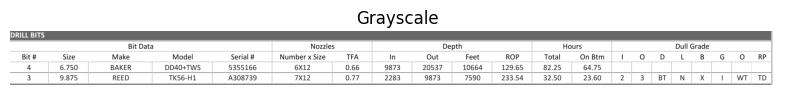

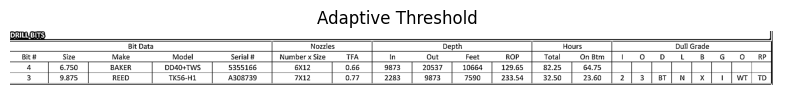

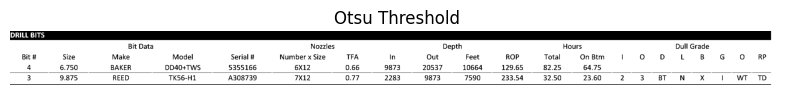

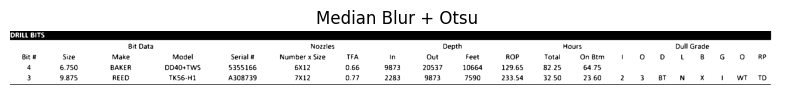

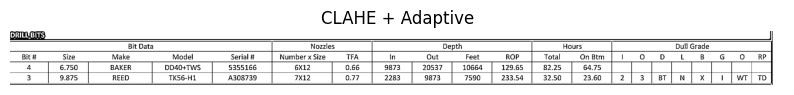

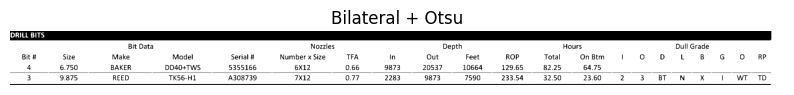

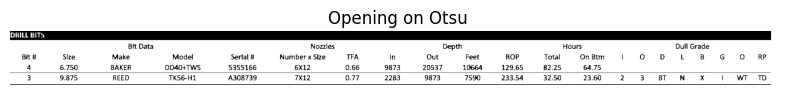

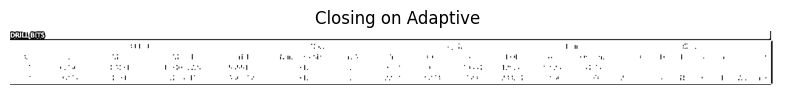

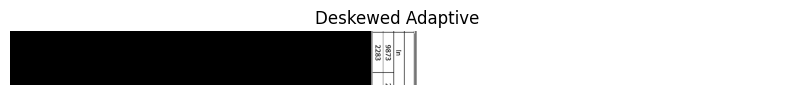

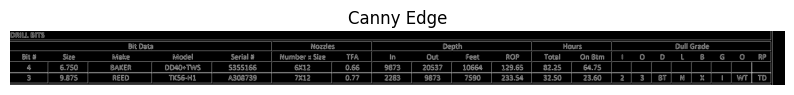

INFO: OCR gray (psm 3): DRILL BITS

Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | oO D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75

3 9.875 REED TK56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 2 3 BT N x | WT TD
INFO:bit_infoExtractor:OCR gray (psm 3): DRILL BITS

Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | oO D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75

3 9.875 REED TK56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 2 3 BT N x | WT TD
INFO: OCR gray (psm 6): Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | ie) D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 308739 7X12 0.77 2283 9873 7590 23


--- OCR Results for Different Preprocessing Methods and PSM Modes ---

Variant: gray
  psm_3: DRILL BITS

Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | oO D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75

3 9.875 REED TK56-H1 A308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 2 3 BT N x | WT TD
  psm_6: Bit Data Nozzles Depth Hours Dull Grade
Bit # Size Make Model Serial # Number x Size TFA In Out Feet ROP Total On Btm | ie) D L B G ie) RP
4 6.750 BAKER DD40+TWS 5355166 6X12 0.66 9873 20537 10664 129.65 82.25 64.75
3 9.875 REED TK56-H1 308739 7X12 0.77 2283 9873 7590 233.54 32.50 23.60 | 2) 3 | BT) N| X| 1 /|WT TD.
  psm_11: Bit Data

Nozzles

Depth

Hours

Dull Grade

Bit #

Size

Make

Model

Serial #

Number x Size

TFA

In

Out

Feet

ROP

Total

On Btm

|

oO

D

L

B

G

ie)

RP

4

6.750

BAKER

DD40+TWS

5355166

6X12

0.66

9873

20537

10664

129.65

82.25

6

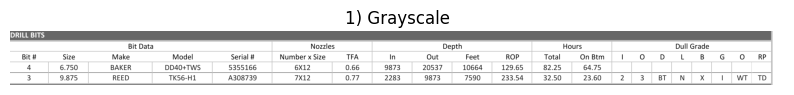

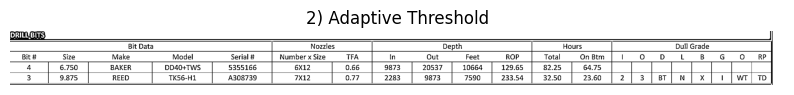

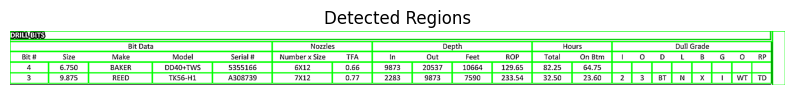

Variant gray with config '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' OCR output: DRILLBITS I
Variant gray with config '--psm 6' OCR output: DRILL BITS |
Variant adaptive with config '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' OCR output: DRILUBITS
Variant adaptive with config '--psm 6' OCR output: DRILUBITS}
Variant otsu with config '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' OCR output: DRILLBITS I
Variant otsu with config '--psm 6' OCR output: DRILL BITS |
OCR Box 0: DRILLBITS I
Variant gray with config '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' OCR output: DRILLBITS
Variant gray with config '--psm 6' OCR output: DRILL BITS
Variant adaptive with config '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' OCR output: 

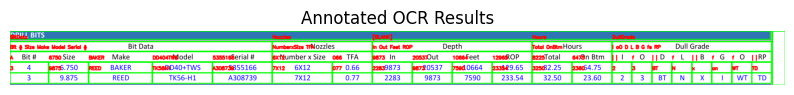

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-7784125023026639>, line 741
    738     logger.info("Data saved successfully in output folder.")
    740 if __name__ == "__main__":
--> 741     main_bit_info_pipeline()

File <command-7784125023026639>, line 727, in main_bit_info_pipeline()
    725 roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    726 annotate_ocr_results(img, roi_texts)
--> 727 bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)
    729 final_output = {"BIT DETAILS": bit_info_list}
    730 logger.info(json.dumps(final_output, indent=4))

TypeError: build_bit_info_dict_from_rois() missing 1 required positional argument: 'orig_img'

In [0]:
import os
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("bit_infoExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# Additional Preprocessing Functions
# ---------------------------------------------------------------------
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image, method="median", ksize=3):
    if method == "median":
        return cv2.medianBlur(image, ksize)
    elif method == "bilateral":
        # Bilateral filtering preserves edges
        return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    else:
        return image

def otsu_threshold(image):
    ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def adaptive_threshold(image, blockSize=15, C=9):
    return cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize, C
    )

def clahe_equalization(image):
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def opening(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def closing(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    if len(coords) == 0:
        return image
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated

def canny_edge(image):
    return cv2.Canny(image, 100, 200)

# ---------------------------------------------------------------------
# Run OCR with Multiple Methods & PSM Configurations
# ---------------------------------------------------------------------
def preprocess_variants(img, debug=False):
    """
    Applies several pre-processing methods to the input image and returns
    a dictionary mapping method names to the processed image.
    """
    variants = {}
    gray = get_grayscale(img)
    variants["gray"] = gray
    if debug:
        show_image("Grayscale", gray, cmap="gray")
    
    # Adaptive threshold on gray image
    adaptive = adaptive_threshold(gray)
    variants["adaptive"] = adaptive
    if debug:
        show_image("Adaptive Threshold", adaptive, cmap="gray")
    
    # Otsu thresholding on gray image
    otsu = otsu_threshold(gray)
    variants["otsu"] = otsu
    if debug:
        show_image("Otsu Threshold", otsu, cmap="gray")
    
    # Median filter then Otsu threshold
    blur = remove_noise(gray, method="median", ksize=3)
    otsu_blur = otsu_threshold(blur)
    variants["otsu_blur"] = otsu_blur
    if debug:
        show_image("Median Blur + Otsu", otsu_blur, cmap="gray")
    
    # CLAHE equalization then Adaptive threshold
    clahe = clahe_equalization(gray)
    clahe_adaptive = adaptive_threshold(clahe)
    variants["clahe_adaptive"] = clahe_adaptive
    if debug:
        show_image("CLAHE + Adaptive", clahe_adaptive, cmap="gray")
    
    # Bilateral filtering then Otsu
    bilateral = remove_noise(gray, method="bilateral")
    otsu_bilateral = otsu_threshold(bilateral)
    variants["otsu_bilateral"] = otsu_bilateral
    if debug:
        show_image("Bilateral + Otsu", otsu_bilateral, cmap="gray")
    
    # Opening then Otsu
    opened = opening(otsu, kernel_size=3)
    variants["opened"] = opened
    if debug:
        show_image("Opening on Otsu", opened, cmap="gray")
    
    # Closing on adaptive threshold
    closed = closing(adaptive, kernel_size=3)
    variants["closed"] = closed
    if debug:
        show_image("Closing on Adaptive", closed, cmap="gray")
    
    # Deskewed adaptive threshold
    deskewed = deskew(adaptive)
    variants["deskewed"] = deskewed
    if debug:
        show_image("Deskewed Adaptive", deskewed, cmap="gray")
    
    # Canny edge (for visualization only)
    canny = canny_edge(gray)
    variants["canny"] = canny
    if debug:
        show_image("Canny Edge", canny, cmap="gray")
    
    return variants

def run_ocr_on_variants(img, debug=False):
    """
    Runs pytesseract on each preprocessed variant with multiple PSM configurations.
    Returns a nested dictionary of OCR outputs: {variant: {psm: text}}.
    """
    variants = preprocess_variants(img, debug=debug)
    ocr_results = {}
    psm_modes = ["3", "6", "11"]  # Fully automatic, Assume a single uniform block, Sparse text.
    for var_key, processed in variants.items():
        ocr_results[var_key] = {}
        for psm in psm_modes:
            config = f"--psm {psm}"
            text = pytesseract.image_to_string(processed, config=config).strip()
            if not text:
                text = "[BLANK]"
            ocr_results[var_key][f"psm_{psm}"] = text
            if debug:
                logger.info(f"OCR {var_key} (psm {psm}): {text}")
    return ocr_results

# ---------------------------------------------------------------------
# Existing Functions for Table Extraction (unchanged)
# ---------------------------------------------------------------------
def annotate_ocr_results(img, roi_texts):
    """
    Draws bounding boxes and OCR text on the image for debugging.
    """
    annotated = img.copy()
    for (x, y, w, h, text) in roi_texts:
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(annotated, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 2, cv2.LINE_AA)
    show_image("Annotated OCR Results", annotated)

def safe_read_image(img_path):
    """
    Reads an image from a local or DBFS path.
    """
    local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    return img

def preprocess_image(img, debug=False):
    """
    Basic pre-processing using adaptive thresholding.
    """
    gray = get_grayscale(img)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    
    thresh = adaptive_threshold(gray)
    if debug:
        show_image("2) Adaptive Threshold", thresh, cmap="gray")
    return thresh

def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    Only keeps bounding boxes larger than (width>30, height>15).
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    
    rois.sort(key=lambda b: (b[1], b[0]))
    
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Regions", debug_img)
    
    return rois

# def perform_ocr_on_rois(img, rois, debug=False):
#     """
#     Performs OCR on each detected text region.
#     Returns list of tuples: (x, y, w, h, text).
#     """
#     results = []
#     for i, (x, y, w, h) in enumerate(rois):
#         roi = img[y:y+h, x:x+w]
#         text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
#         results.append((x, y, w, h, text))
#         if debug:
#             logger.info(f"OCR Box {i}: {text}")
#     return results

# def build_bit_info_dict_from_rois(roi_texts, debug=False):
#     """
#     Custom parsing for the multi-row header layout.
#     """
#     row_tolerance = 10
#     grouped_rows = []
#     current_row = []
#     prev_y = None

#     for (x, y, w, h, text) in roi_texts:
#         if prev_y is None or abs(y - prev_y) <= row_tolerance:
#             current_row.append((x, y, w, h, text))
#         else:
#             grouped_rows.append(current_row)
#             current_row = [(x, y, w, h, text)]
#         prev_y = y
#     if current_row:
#         grouped_rows.append(current_row)

#     row_strings = []
#     for i, row_cells in enumerate(grouped_rows):
#         row_cells.sort(key=lambda c: c[0])
#         line = " ".join(cell[4] for cell in row_cells).replace("\n", " ").strip()
#         row_strings.append(line)
#         if debug:
#             logger.info(f"Row {i} => {line}")

#     if len(row_strings) < 3:
#         logger.warning("Not enough rows found for this layout.")
#         return [], pd.DataFrame()

#     super_header_line = row_strings[1] if len(row_strings) > 1 else ""
#     sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
#     data_lines        = row_strings[3:]

#     if debug:
#         logger.info(f"Super Headers => {super_header_line}")
#         logger.info(f"Sub Headers => {sub_header_line}")
#         logger.info(f"Data Lines => {data_lines}")

#     final_columns = [
#         "Bit #", "Size", "Make", "Model", "Serial #",         # 5
#         "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
#         "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
#         "Hours-Total", "Hours-On Btm",                        # 2
#         "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
#         "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
#     ]

#     structured_data = []
#     for line in data_lines:
#         tokens = line.split()
#         if len(tokens) < 21:
#             tokens += [""] * (21 - len(tokens))
#         elif len(tokens) > 21:
#             tokens = tokens[:21]

#         row_dict = {col_name: tokens[col_idx] for col_idx, col_name in enumerate(final_columns)}
#         structured_data.append(row_dict)
#         if debug:
#             logger.info(f"Parsed row => {row_dict}")

#     df = pd.DataFrame(structured_data)
#     if debug:
#         logger.info("DataFrame Preview:")
#         logger.info(df.head())

#     df.to_csv("bit_info_data.csv", index=False)
#     logger.info("Data saved successfully as CSV.")

#     structured_data_json = df.to_dict(orient='records')
#     with open("bit_info_data.json", "w") as json_file:
#         json.dump(structured_data_json, json_file, indent=4)
#     logger.info("Data saved successfully in JSON format.")

#     return structured_data_json, df

# # def perform_ocr_on_rois(img, rois, debug=False):
# #     """
# #     Performs OCR on each detected text region.
# #     Returns list of tuples: (x, y, w, h, text).
# #     We expand the ROI by a few pixels to include a bit more context,
# #     and we pass a whitelist so that characters like "I" are not dropped.
# #     """
# #     results = []
# #     # Define a whitelist including uppercase letters and digits (add more if needed)
# #     ocr_config = "--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
# #     for i, (x, y, w, h) in enumerate(rois):
# #         # Expand the ROI by 2 pixels on each side (ensure indices are in bounds)
# #         pad = 2
# #         x0 = max(x - pad, 0)
# #         y0 = max(y - pad, 0)
# #         x1 = x + w + pad
# #         y1 = y + h + pad
# #         roi = img[y0:y1, x0:x1]
# #         text = pytesseract.image_to_string(roi, config=ocr_config).strip()
# #         # If OCR returns an empty string, then mark as [BLANK]
# #         if not text:
# #             text = "[BLANK]"
# #         results.append((x, y, w, h, text))
# #         if debug:
# #             logger.info(f"OCR Box {i}: {text}")
# #     return results

# # (The rest of your code remains unchanged.)
# def perform_ocr_on_rois(img, rois, debug=False):
#     """
#     Performs OCR on each detected text region.
#     Expands the ROI slightly to provide context.
#     Applies a whitelist to encourage recognition of expected characters.
#     If the OCR result is blank and the ROI width is very small,
#     assume it may be the letter "I" and substitute accordingly.
#     Returns a list of tuples: (x, y, w, h, text).
#     """
#     results = []
#     # Whitelist includes letters and digits (add more as needed)
#     ocr_config = "--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
#     for i, (x, y, w, h) in enumerate(rois):
#         pad = 2
#         x0 = max(x - pad, 0)
#         y0 = max(y - pad, 0)
#         x1 = x + w + pad
#         y1 = y + h + pad
#         roi = img[y0:y1, x0:x1]
#         text = pytesseract.image_to_string(roi, config=ocr_config).strip()
#         # If OCR returns an empty string, mark as "[BLANK]"
#         if not text:
#             text = "[BLANK]"
#         # Post-processing: if text is blank and the ROI is narrow, assume it should be "I"
#         if text == "[BLANK]" and w < 15:
#             text = "I"
#         results.append((x, y, w, h, text))
#         if debug:
#             logger.info(f"OCR Box {i}: {text}")
#     return results

import cv2
import pytesseract
from collections import Counter

def aggregate_ocr(roi, debug=False):
    """
    For the given ROI image, run OCR on several pre–processed variants and aggregate
    the outputs. Returns the candidate text that appears most frequently (or, if needed,
    the longest non-blank one if the majority vote is blank).
    """
    # Convert to grayscale if necessary
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi

    # Prepare different pre–processed variants
    variants = {}
    variants["gray"] = gray
    variants["adaptive"] = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                 cv2.THRESH_BINARY, 15, 9)
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    variants["otsu"] = otsu

    # Define a couple of OCR configurations
    configs = [
        "--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz",
        "--psm 6"
    ]

    outputs = []
    for var_name, proc_img in variants.items():
        for config in configs:
            text = pytesseract.image_to_string(proc_img, config=config).strip()
            # Use "[BLANK]" if nothing was detected
            output = text if text else "[BLANK]"
            outputs.append(output)
            if debug:
                print(f"Variant {var_name} with config '{config}' OCR output: {output}")

    # Aggregate the outputs using a simple majority vote
    counter = Counter(outputs)
    common, freq = counter.most_common(1)[0]
    # If the majority candidate is blank, try to choose a non-blank candidate (based on frequency and length)
    if common == "[BLANK]":
        non_blank = [t for t in outputs if t != "[BLANK]"]
        if non_blank:
            common = max(non_blank, key=lambda t: (counter[t], len(t)))
    return common

def perform_ocr_on_rois(img, rois, debug=False):
    """
    For each detected text region (ROI), expand the ROI slightly and then dynamically
    aggregate OCR outputs from several pre-processed variants.
    Returns a list of tuples: (x, y, w, h, aggregated_text).
    """
    results = []
    pad = 2  # slight expansion of the ROI
    for i, (x, y, w, h) in enumerate(rois):
        x0 = max(x - pad, 0)
        y0 = max(y - pad, 0)
        x1 = x + w + pad
        y1 = y + h + pad
        roi = img[y0:y1, x0:x1]
        aggregated_text = aggregate_ocr(roi, debug=debug)
        results.append((x, y, w, h, aggregated_text))
        if debug:
            print(f"OCR Box {i}: {aggregated_text}")
    return results


def build_bit_info_dict_from_rois(roi_texts, debug=False):
    """
    Custom parsing for the multi-row header layout.
    Note: If a token comes as [BLANK] but based on context it should be 'I',
    you might perform additional post-processing here.
    """
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)

    row_strings = []
    for i, row_cells in enumerate(grouped_rows):
        row_cells.sort(key=lambda c: c[0])
        # Join texts with a space – you might add extra logic here if needed.
        line = " ".join(cell[4] for cell in row_cells).replace("\n", " ").strip()
        row_strings.append(line)
        if debug:
            logger.info(f"Row {i} => {line}")

    # Continue processing as before...
    if len(row_strings) < 3:
        logger.warning("Not enough rows found for this layout.")
        return [], pd.DataFrame()

    super_header_line = row_strings[1] if len(row_strings) > 1 else ""
    sub_header_line   = row_strings[2] if len(row_strings) > 2 else ""
    data_lines        = row_strings[3:]

    if debug:
        logger.info(f"Super Headers => {super_header_line}")
        logger.info(f"Sub Headers => {sub_header_line}")
        logger.info(f"Data Lines => {data_lines}")

    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",               # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",   # 4
        "Hours-Total", "Hours-On Btm",                        # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]

    structured_data = []
    for line in data_lines:
        tokens = line.split()
        if len(tokens) < 21:
            tokens += [""] * (21 - len(tokens))
        elif len(tokens) > 21:
            tokens = tokens[:21]
        row_dict = {col_name: tokens[col_idx] for col_idx, col_name in enumerate(final_columns)}
        structured_data.append(row_dict)
        if debug:
            logger.info(f"Parsed row => {row_dict}")

    df = pd.DataFrame(structured_data)
    if debug:
        logger.info("DataFrame Preview:")
        logger.info(df.head())

    df.to_csv("bit_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")

    structured_data_json = df.to_dict(orient='records')
    with open("bit_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")

    return structured_data_json, df

import numpy as np
import pandas as pd
import json
import cv2
import logging

logger = logging.getLogger("bit_infoExtractor")
logger.setLevel(logging.INFO)

def build_bit_info_dict_from_rois(roi_texts, orig_img, debug=False):
    """
    Dynamically builds the table from OCR-detected ROIs.
    
    Expected layout:
      - Row 0: Title (ignored)
      - Row 1: Super-header (ignored)
      - Row 2: Subheader (should yield the column names when split; we ignore its text but use its geometry)
      - Rows 3+: Data rows
      
    The function groups ROIs by similar y-coordinates (rows), then for each data row,
    it assigns each ROI to a column based on its center x relative to the subheader's ROI centers.
    For each column, all assigned OCR texts (and their bounding boxes) are stored.
    
    Then, for the Dull Grade-G column (expected index 18 in final_columns), if the aggregated text
    is not exactly one uppercase letter (e.g. "I"), we re-crop that cell from orig_img and re-run OCR
    with a configuration optimized for a single character.
    """
    # Group ROIs by row (using a y-coordinate tolerance)
    row_tolerance = 10
    grouped_rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            grouped_rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        grouped_rows.append(current_row)
    
    if debug:
        for idx, row in enumerate(grouped_rows):
            sorted_texts = [cell[4] for cell in sorted(row, key=lambda c: c[0])]
            logger.info(f"Row {idx}: {sorted_texts}")
    
    if len(grouped_rows) < 3:
        logger.warning("Not enough rows for expected header + data layout.")
        return [], pd.DataFrame()
    
    # Use row index 2 as subheader.
    header_row = sorted(grouped_rows[2], key=lambda c: c[0])
    expected_columns = 21
    if len(header_row) != expected_columns:
        logger.warning(f"Expected {expected_columns} header cells, but found {len(header_row)}.")
    
    # Compute header centers (x + w/2) and sort them
    header_centers = [x + w/2 for (x, y, w, h, text) in header_row]
    header_centers.sort()
    
    # Derive column boundaries: left boundary is midpoint to previous header center, etc.
    col_boundaries = []
    for i, center in enumerate(header_centers):
        left_bound = -np.inf if i == 0 else (header_centers[i-1] + center) / 2
        right_bound = np.inf if i == len(header_centers)-1 else (center + header_centers[i+1]) / 2
        col_boundaries.append((left_bound, right_bound))
    
    # Define final column names (the fixed layout as known)
    final_columns = [
        "Bit #", "Size", "Make", "Model", "Serial #",         # 5
        "Nozzle-(Number x Size)", "Nozzle-TFA",                # 2
        "Depth-In", "Depth-Out", "Depth-Feet", "Depth-ROP",    # 4
        "Hours-Total", "Hours-On Btm",                         # 2
        "Dull Grade-I", "Dull Grade-O1", "Dull Grade-D", "Dull Grade-L", 
        "Dull Grade-B", "Dull Grade-G", "Dull Grade-O2", "Dull Grade-RP"  # 8
    ]
    if len(final_columns) != expected_columns:
        raise ValueError("Final columns count does not match expected header cell count.")
    
    data_dicts = []
    # For each data row (rows 3 onward), build assignments.
    for row in grouped_rows[3:]:
        # For each column, store a list of tuples: (x, text, bounding box)
        cell_assignments = {col: [] for col in final_columns}
        for (x, y, w, h, text) in row:
            center = x + w/2
            for idx, (left, right) in enumerate(col_boundaries):
                if left <= center < right:
                    col_name = final_columns[idx]
                    cell_assignments[col_name].append((x, text, (x, y, w, h)))
                    break
        # For each column, sort by x and join texts
        row_dict = {}
        cell_boxes = {}  # keep track of the bounding boxes for each column
        for col in final_columns:
            if cell_assignments[col]:
                # Sort by x coordinate
                sorted_vals = sorted(cell_assignments[col], key=lambda tup: tup[0])
                texts = [tup[1] for tup in sorted_vals]
                row_dict[col] = " ".join(texts).strip()
                # Combine bounding boxes (take min x, min y, max(x+w), max(y+h))
                boxes = [tup[2] for tup in sorted_vals]
                xs = [b[0] for b in boxes]
                ys = [b[1] for b in boxes]
                xws = [b[0]+b[2] for b in boxes]
                yhs = [b[1]+b[3] for b in boxes]
                combined_box = (min(xs), min(ys), max(xws)-min(xs), max(yhs)-min(ys))
                cell_boxes[col] = combined_box
            else:
                row_dict[col] = ""
                cell_boxes[col] = None
        # For the Dull Grade-G column (index 18), check if the text looks unsatisfactory.
        target_col = final_columns[18]  # "Dull Grade-G"
        candidate = row_dict[target_col]
        # Define a helper: acceptable if it is a single uppercase letter.
        def acceptable(val):
            return len(val) == 1 and val.isalpha() and val.upper() == val
        if not acceptable(candidate):
            # If we have a bounding box for this column, re-run OCR on that cell with a config optimized for a single character.
            box = cell_boxes[target_col]
            if box is not None:
                x0, y0, w_box, h_box = box
                # Crop the region from the original image.
                cell_img = orig_img[y0:y0+h_box, x0:x0+w_box]
                # Use a config that forces psm=10 (single character) and whitelists uppercase letters.
                config = "--psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ"
                new_val = pytesseract.image_to_string(cell_img, config=config).strip()
                if acceptable(new_val):
                    row_dict[target_col] = new_val
                    if debug:
                        logger.info(f"Re-OCR for column '{target_col}' improved value to: {new_val}")
        data_dicts.append(row_dict)
        if debug:
            logger.info(f"Parsed row => {row_dict}")
    
    df = pd.DataFrame(data_dicts)
    df.to_csv("bit_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")
    structured_data_json = df.to_dict(orient="records")
    with open("bit_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")
    
    return structured_data_json, df


# ---------------------------------------------------------------------
# Main Pipeline Function
# ---------------------------------------------------------------------
def main_bit_info_pipeline():
    """
    Main pipeline for extracting the BIT DETAILS table and experimenting
    with different OCR pre-processing methods.
    """
    # Replace with your actual image path
    bit_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_6.png"

    try:
        img = safe_read_image(bit_info_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Run and compare multiple OCR pre-processing variants with multiple PSM modes
    ocr_outputs = run_ocr_on_variants(img, debug=True)
    print("\n--- OCR Results for Different Preprocessing Methods and PSM Modes ---")
    for variant, results in ocr_outputs.items():
        print(f"\nVariant: {variant}")
        for psm, text in results.items():
            print(f"  {psm}: {text}")

    # 2) Continue with the table extraction pipeline using one approach (e.g., adaptive threshold)
    thresh_img = preprocess_image(img, debug=True)
    rois = detect_text_regions(thresh_img, debug=True)
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    annotate_ocr_results(img, roi_texts)
    bit_info_list, df = build_bit_info_dict_from_rois(roi_texts, debug=True)

    final_output = {"BIT DETAILS": bit_info_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    output_folder = "/dbfs/mnt/mini-proj-dd/final_bit_info_results"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "bit_info_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "bit_info_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")

if __name__ == "__main__":
    main_bit_info_pipeline()
